In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%xmode minimal
import warnings

warnings.filterwarnings("ignore")

Exception reporting mode: Minimal


In [3]:
%matplotlib inline

In [4]:
import cmocean
import palettable
from matplotlib import pyplot as plt

In [5]:
from IPython.display import clear_output

In [6]:
import pathlib
import sys

In [7]:
import seaborn as sns

In [8]:
from seasonal_forecasting import C3S, domains, geo, plot, utils, verification

In [9]:
from calendar import month_abbr
from datetime import datetime, timedelta

In [10]:
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import regionmask
import xarray as xr

### climpred HindcastEnsemble Class + logging

In [11]:
import logging

from climpred import HindcastEnsemble

### progress bar for dask compute 

In [12]:
from dask.diagnostics import ProgressBar

### path definitions 

In [13]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()

In [14]:
fig_path = pathlib.Path("../figures/verification/SST")

In [15]:
fig_path.mkdir(parents=True, exist_ok=True)

In [16]:
fig_path

PosixPath('../figures/verification/SST')

### parameters for papermill

In [17]:
domain_name = "NZ"
use_verif = "oisst"
GCMs = [
    "ECMWF",
    "UKMO",
    "METEO_FRANCE",
    "DWD",
    "CMCC",
    "NCEP",
    "JMA",
    "ECCC_CanCM4i",
    "ECCC_GEM5_NEMO",
]
varname = "sst"
period = "monthly"  # 'seasonal' or 'monthly'
year_start = 1993
year_end = 2016
obs_to_1deg = False
drop_inits = [
    datetime(1997, 8, 1),
    datetime(1993, 1, 1),
]  # initial times to drop because of issues in NCEP and UKMO respectively
climpred_verbose = False

### logging, to see what `climpred` is doing under the hood, if `climpred_verbose` is set to True, then all inits and corresponding verif times are printed

### Note: setting it to True causes issues with Matplotlib, which outputs endless debug messages related to the font manager, so setting it to `False` is safer

In [18]:
logger = logging.getLogger()

if climpred_verbose:

    logger.setLevel(logging.DEBUG)

else:

    logger.setLevel(logging.INFO)

### dictionnary of domains 

In [19]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

In [20]:
domain = domains.domains[domain_name]

### creates a map delineating the validation domain 

In [21]:
area = geo.gpd_from_domain(*domain)

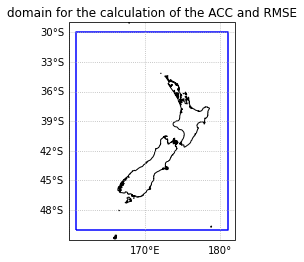

In [22]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
area.geometry.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='b')
ax.coastlines(resolution='10m');
ax.set_title('domain for the calculation of the ACC and RMSE')
gl = ax.gridlines(draw_labels=True, linestyle=':', xlocs=np.arange(-180, 180, 10), crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False

### reads in the verification dataset 

In [23]:
if use_verif == "ersst":
    dset_obs, dset_obs_anoms = verification.get_ERSST(
        access="opendap", start=year_start, end=year_end, detrend=True
    )
elif use_verif == "oisst":
    dset_obs, dset_obs_anoms = verification.get_OISST(start=year_start, end=year_end, detrend=True)

### regrid to 1deg X 1deg (if `obs_to_1deg` is set to True)

In [24]:
if obs_to_1deg:
    dset_obs = utils.interp_to_1x(dset_obs)

### now selects domain 

In [25]:
dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))

In [26]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 288, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (time, lat, lon) float32 10.46 10.46 10.43 ... 21.96 21.89 21.8

### creates a mask from the observational dataset 

In [27]:
mask_obs = dset_obs.mean(dim="time")

In [28]:
mask_obs = mask_obs.where(np.isnan(mask_obs), 1)

In [29]:
mask_obs = mask_obs.rename({varname: "mask"})["mask"]

### plots the mask 

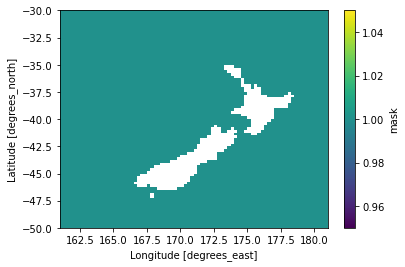

In [30]:
mask_obs.plot()

### calculates seasonal averages if 'seasonal' 

In [31]:
if period == "seasonal":
    dset_obs = dset_obs.rolling({"time": 3}, min_periods=3).mean("time")
    dset_obs = dset_obs.isel(time=slice(2, None))

### Now reads in the GCM hindcasts (reforecasts)

In [32]:
dpath = "/media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/"

In [33]:
gcm = C3S.get_one_GCM(dpath=dpath, GCM='NCEP', varname=varname, anomalies=False, ensemble_mean=False, domain=domain)

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/NCEP/SST
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/NCEP/SST/ensemble_seas_forecasts_sst_from_1993_01_NCEP.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/NCEP/SST/ensemble_seas_forecasts_sst_from_2016_12_NCEP.netcdf


In [34]:
gcm

<xarray.Dataset>
Dimensions:  (lon: 21, lat: 21, member: 28, step: 5, time: 288)
Coordinates:
  * lon      (lon) float32 161.0 162.0 163.0 164.0 ... 178.0 179.0 180.0 181.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -33.0 -32.0 -31.0 -30.0
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26 27
  * step     (step) int64 1 2 3 4 5
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
Data variables:
    sst      (time, step, member, lat, lon) float32 10.83 11.03 ... nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-01 01:23:42 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [35]:
def interp_NCEP(gcm, gcm_name='NCEP', sst_hindcast_records='./SST_hindcast_summary.csv'): 
    
    sst_hindcasts_nmembers = pd.read_csv(sst_hindcast_records, index_col=0, parse_dates=True)
    
    sst_hindcasts_nmembers = sst_hindcasts_nmembers.sort_index()
    
    gcm_nmembers = sst_hindcasts_nmembers.loc[:,gcm_name]
    
    arrt_interp = []
    
    for t in gcm.time.data: 
        
        arrt = gcm.sel(time=t)
    
        arrt = arrt.isel(member=slice(None, gcm_nmembers.loc[t,]))
        
        arrt = utils.interpolate_NaN_da(arrt).load()
        
        arrt= arrt.expand_dims({'time':[t]})
        
        arrt_interp.append(arrt)
    
    arrt_interp = xr.concat(arrt_interp, dim='time')
    
    arrt_interp = arrt_interp.sortby('time')
    
    return arrt_interp

### calculates seasonal averages if 'seasonal'

In [36]:
if period == "seasonal":
    gcm = gcm.rolling({"step": 3}, min_periods=3).mean("step")
    gcm = gcm.sel(step=slice(3, None))

### transpose to have GCM and time as the first 2 dimensions 

In [37]:
gcm = gcm.transpose( "time", "member", "step", "lat", "lon")

In [38]:
gcm

<xarray.Dataset>
Dimensions:  (lon: 21, lat: 21, member: 28, step: 5, time: 288)
Coordinates:
  * lon      (lon) float32 161.0 162.0 163.0 164.0 ... 178.0 179.0 180.0 181.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -33.0 -32.0 -31.0 -30.0
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26 27
  * step     (step) int64 1 2 3 4 5
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
Data variables:
    sst      (time, member, step, lat, lon) float32 10.83 11.03 ... nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-01 01:23:42 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

### Now, if `obs_to_1deg` is set to False, it means that the MME needs to be interpolated onto the obs dataset grid 

In [39]:
if not (obs_to_1deg):
    gcm = gcm.interp_like(dset_obs[["lon", "lat"]])

### re-chunk, each chunk will take ~ 7 Mb in memory

In [40]:
gcm = gcm.chunk({"member": -1, "time": -1, "step": -1, "lon": 'auto', "lat": 'auto'})

### we apply the observational land sea mask to the MME 

In [41]:
gcm = gcm * mask_obs

### we can now just fill the missing values (land) with 0, as the subsequent operations do not support missing values 

In [42]:
gcm = gcm.fillna(0.0)

In [43]:
dset_obs = dset_obs.fillna(0.0)

In [44]:
with ProgressBar():
    gcm = gcm.compute()
    dset_obs = dset_obs.compute()

[########################################] | 100% Completed | 520.49 ms


### process to make all the variables and dimension names compatible with climpred

In [45]:
gcm = verification.process_for_climpred(gcm)

In [46]:
gcm

<xarray.Dataset>
Dimensions:  (init: 288, member: 28, lead: 5, lat: 80, lon: 80)
Coordinates:
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26 27
  * lead     (lead) int64 1 2 3 4 5
  * init     (init) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
Data variables:
    sst      (init, member, lead, lat, lon) float32 10.94 10.99 ... 0.0 0.0

### re-chunk the MME 

In [47]:
gcm = gcm.chunk({"init": -1, "lead": 1, "lat": -1, "lon": -1})

### re-chunk the observations 

In [48]:
dset_obs = dset_obs.chunk({"time": -1, "lat": -1, "lon": -1})

In [49]:
dset_obs.chunks

Frozen({'time': (288,), 'lat': (80,), 'lon': (80,)})

### Try and create the hindcast ensemble over all the GCMs (including the MME)

In [50]:
hindcast = HindcastEnsemble(gcm)

In [51]:
hindcast

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 288, member: 28, lead: 5, lat: 80, lon: 80)
Coordinates:
 * member (member) int32 0 1 2 3 4 5 6 7 8 ... 19 20 21 22 23 24 25 26 27
 * lead (lead) int64 1 2 3 4 5
 * init (init) object 1993-01-01 00:00:00 ... 2016-12-01 00:00:00
 * lon (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
 * lat (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
 valid_time (lead, init) object 1993-02-01 00:00:00 ... 2017-05-01 00:00:00
Data variables:
 sst (init, member, lead, lat, lon) float32 dask.array<chunksize=(288, 28, 1, 80, 80), meta=np.ndarray> Initialized Ensemble Dimensions: init : 288 member : 28 lead : 5 lat : 80 lon : 80 Coordinates: (6) member (member) int32 0 1 2 3 4 5 6 ... 22 23 24 25 26 27 long_name : Member standard_name : realization description : Realization is used to label a dimension that can be thought of as a statistical sample, e.g., labelling members of a model ensemble. array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int32) lead (lead) int64 1 2 3 4 5 units : months standard_name : forecast_period long_name : Lead description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([1, 2, 3, 4, 5]) init (init) object 1993-01-01 00:00:00 ... 2016-12-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1993, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 2, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 3, 1, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2016, 10, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 11, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) lon (lon) float32 161.1 161.4 161.6 ... 180.6 180.9 long_name : Longitude standard_name : longitude units : degrees_east actual_range : [1.25000e-01 3.59875e+02] axis : X amip : longitude description : Longitude is positive eastward; its units of degree_east (or equivalent) indicate this explicitly. In a latitude-longitude system defined with respect to a rotated North Pole, the standard name of grid_longitude should be used instead of longitude. Grid longitude is positive in the grid-eastward direction, but its units should be plain degree. array([161.125, 161.375, 161.625, 161.875, 162.125, 162.375, 162.625, 162.875,
 163.125, 163.375, 163.625, 163.875, 164.125, 164.375, 164.625, 164.875,
 165.125, 165.375, 165.625, 165.875, 166.125, 166.375, 166.625, 166.875,
 167.125, 167.375, 167.625, 167.875, 168.125, 168.375, 168.625, 168.875,
 169.125, 169.375, 169.625, 169.875, 170.125, 170.375, 170.625, 170.875,
 171.125, 171.375, 171.625, 171.875, 172.125, 172.375, 172.625, 172.875,
 173.125, 173.375, 173.625, 173.875, 174.125, 174.375, 174.625, 174.875,
 175.125, 175.375, 175.625, 175.875, 176.125, 176.375, 176.625, 176.875,
 177.125, 177.375, 177.625, 177.875, 178.125, 178.375, 178.625, 178.875,
 179.125, 179.375, 179.625, 179.875, 180.125, 180.375, 180.625, 180.875],
 dtype=float32) lat (lat) float32 -49.88 -49.62 ... -30.38 -30.12 long_name : Latitude standard_name : latitude units : degrees_north actual_range : [-89.875 89.875] axis : Y amip : latitude description : Latitude is positive northward; its units of degree_north (or equivalent) indicate this explicitly. In a latitude-longitude system defined with respect to a rotated North Pole, the standard name of grid_latitude should be used instead of latitude. Grid latitude is po

### we then need to *repeat* the observation for each GCM (+MME) prior to merging 

### Now add the observations to the dataset 

In [52]:
hindcast = hindcast.add_observations(dset_obs)

In [53]:
hindcast

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 288, member: 28, lead: 5, lat: 80, lon: 80)
Coordinates:
 * member (member) int32 0 1 2 3 4 5 6 7 8 ... 19 20 21 22 23 24 25 26 27
 * lead (lead) int64 1 2 3 4 5
 * init (init) object 1993-01-01 00:00:00 ... 2016-12-01 00:00:00
 * lon (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
 * lat (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
 valid_time (lead, init) object 1993-02-01 00:00:00 ... 2017-05-01 00:00:00
Data variables:
 sst (init, member, lead, lat, lon) float32 dask.array<chunksize=(288, 28, 1, 80, 80), meta=np.ndarray> Initialized Ensemble Dimensions: init : 288 member : 28 lead : 5 lat : 80 lon : 80 Coordinates: (6) member (member) int32 0 1 2 3 4 5 6 ... 22 23 24 25 26 27 long_name : Member standard_name : realization description : Realization is used to label a dimension that can be thought of as a statistical sample, e.g., labelling members of a model ensemble. array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int32) lead (lead) int64 1 2 3 4 5 units : months standard_name : forecast_period long_name : Lead description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([1, 2, 3, 4, 5]) init (init) object 1993-01-01 00:00:00 ... 2016-12-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1993, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 2, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 3, 1, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2016, 10, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 11, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) lon (lon) float32 161.1 161.4 161.6 ... 180.6 180.9 long_name : Longitude standard_name : longitude units : degrees_east actual_range : [1.25000e-01 3.59875e+02] axis : X amip : longitude description : Longitude is positive eastward; its units of degree_east (or equivalent) indicate this explicitly. In a latitude-longitude system defined with respect to a rotated North Pole, the standard name of grid_longitude should be used instead of longitude. Grid longitude is positive in the grid-eastward direction, but its units should be plain degree. array([161.125, 161.375, 161.625, 161.875, 162.125, 162.375, 162.625, 162.875,
 163.125, 163.375, 163.625, 163.875, 164.125, 164.375, 164.625, 164.875,
 165.125, 165.375, 165.625, 165.875, 166.125, 166.375, 166.625, 166.875,
 167.125, 167.375, 167.625, 167.875, 168.125, 168.375, 168.625, 168.875,
 169.125, 169.375, 169.625, 169.875, 170.125, 170.375, 170.625, 170.875,
 171.125, 171.375, 171.625, 171.875, 172.125, 172.375, 172.625, 172.875,
 173.125, 173.375, 173.625, 173.875, 174.125, 174.375, 174.625, 174.875,
 175.125, 175.375, 175.625, 175.875, 176.125, 176.375, 176.625, 176.875,
 177.125, 177.375, 177.625, 177.875, 178.125, 178.375, 178.625, 178.875,
 179.125, 179.375, 179.625, 179.875, 180.125, 180.375, 180.625, 180.875],
 dtype=float32) lat (lat) float32 -49.88 -49.62 ... -30.38 -30.12 long_name : Latitude standard_name : latitude units : degrees_north actual_range : [-89.875 89.875] axis : Y amip : latitude description : Latitude is positive northward; its units of degree_north (or equivalent) indicate this explicitly. In a latitude-longitude system defined with respect to a rotated North Pole, the standard name of grid_latitude should be used instead of latitude. Grid latitude is po

<Observations>
Dimensions: (time: 288, lat: 80, lon: 80)
Coordinates:
 * time (time) object 1993-01-01 00:00:00 ... 2016-12-01 00:00:00
 * lat (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
 * lon (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
 sst (time, lat, lon) float32 dask.array<chunksize=(288, 80, 80), meta=np.ndarray> Observations Dimensions: time : 288 lat : 80 lon : 80 Coordinates: (3) time (time) object 1993-01-01 00:00:00 ... 2016-12-... long_name : time standard_name : time array([cftime.DatetimeProlepticGregorian(1993, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 2, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 3, 1, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2016, 10, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 11, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) lat (lat) float32 -49.88 -49.62 ... -30.38 -30.12 long_name : Latitude standard_name : latitude units : degrees_north actual_range : [-89.875 89.875] axis : Y array([-49.875, -49.625, -49.375, -49.125, -48.875, -48.625, -48.375, -48.125,
 -47.875, -47.625, -47.375, -47.125, -46.875, -46.625, -46.375, -46.125,
 -45.875, -45.625, -45.375, -45.125, -44.875, -44.625, -44.375, -44.125,
 -43.875, -43.625, -43.375, -43.125, -42.875, -42.625, -42.375, -42.125,
 -41.875, -41.625, -41.375, -41.125, -40.875, -40.625, -40.375, -40.125,
 -39.875, -39.625, -39.375, -39.125, -38.875, -38.625, -38.375, -38.125,
 -37.875, -37.625, -37.375, -37.125, -36.875, -36.625, -36.375, -36.125,
 -35.875, -35.625, -35.375, -35.125, -34.875, -34.625, -34.375, -34.125,
 -33.875, -33.625, -33.375, -33.125, -32.875, -32.625, -32.375, -32.125,
 -31.875, -31.625, -31.375, -31.125, -30.875, -30.625, -30.375, -30.125],
 dtype=float32) lon (lon) float32 161.1 161.4 161.6 ... 180.6 180.9 long_name : Longitude standard_name : longitude units : degrees_east actual_range : [1.25000e-01 3.59875e+02] axis : X array([161.125, 161.375, 161.625, 161.875, 162.125, 162.375, 162.625, 162.875,
 163.125, 163.375, 163.625, 163.875, 164.125, 164.375, 164.625, 164.875,
 165.125, 165.375, 165.625, 165.875, 166.125, 166.375, 166.625, 166.875,
 167.125, 167.375, 167.625, 167.875, 168.125, 168.375, 168.625, 168.875,
 169.125, 169.375, 169.625, 169.875, 170.125, 170.375, 170.625, 170.875,
 171.125, 171.375, 171.625, 171.875, 172.125, 172.375, 172.625, 172.875,
 173.125, 173.375, 173.625, 173.875, 174.125, 174.375, 174.625, 174.875,
 175.125, 175.375, 175.625, 175.875, 176.125, 176.375, 176.625, 176.875,
 177.125, 177.375, 177.625, 177.875, 178.125, 178.375, 178.625, 178.875,
 179.125, 179.375, 179.625, 179.875, 180.125, 180.375, 180.625, 180.875],
 dtype=float32) Data variables: (1) sst (time, lat, lon) float32 dask.array<chunksize=(288, 80, 80), meta=np.ndarray> 
 
 
 
 
 
 
 Array 
 Chunk 
 
 
 
 
 
 Bytes 
 7.03 MiB 
 7.03 MiB 
 
 
 
 Shape 
 (288, 80, 80) 
 (288, 80, 80) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float32 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 80 
 80 
 288 
 
 
 
 Indexes: (3) time PandasIndex PandasIndex(CFTimeIndex([1993-01-01 00:00:00, 1993-02-01 00:00:00, 1993-03-01 00:00:00,
 1993-04-01 00:00:00, 1993-05-01 00:00:00, 1993-06-01 00:00:00,
 1993-07-01 00:00:00, 1993-08-01 00:00:00, 1993-09-01 00:00:00,
 1993-10-01 00:00:00,
 ...
 2016-03-01 00:00:00, 2016-04-01 00:00:00, 2016-05-01 00:00:00,
 2016-06-01 00:00:00, 2016-07-01 00:00:00, 2016-08-01 00:00:00,
 2016-09-01 00:00:00, 2016-10-01 00:00:00, 2016-11-01 00:00:00,
 2016-12-0

In [54]:
q = [0.9]  # terciles by month
forecast_edges = (
    hindcast.get_initialized()
    .groupby("init.month")
    .quantile(q=q, dim=["init", "member"])
    .rename({"quantile": "category_edge"})
)

In [55]:
obs_edges = (
    hindcast.get_observations()
    .groupby("time.month")
    .quantile(q=q, dim="time")
    .rename({"quantile": "category_edge"})
)

In [56]:
category_edges = (obs_edges, forecast_edges)

In [57]:
rps = hindcast.verify(
    metric="rps",
    comparison="m2o",
    dim=["member", "init"],
    alignment="same_verifs",
    category_edges=category_edges,
)

INFO:root:initialized | lead: 01 | inits: 1993-05-01 00:00:00-2016-11-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 02 | inits: 1993-04-01 00:00:00-2016-10-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 03 | inits: 1993-03-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-01-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00


In [58]:
rps = rps * mask_obs

In [59]:
with ProgressBar(): 
    
    rps = rps.compute()

[########################################] | 100% Completed | 112.38 s


In [60]:
rps

<xarray.Dataset>
Dimensions:  (lead: 5, lon: 80, lat: 80)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
    skill    <U11 'initialized'
Data variables:
    sst      (lead, lat, lon) float64 0.128 0.1312 0.1312 ... 0.09514 0.09425

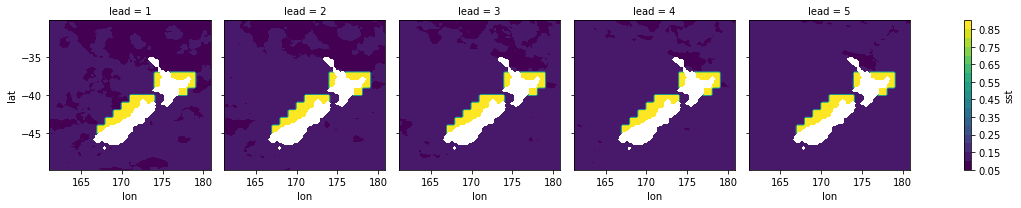

In [61]:
rps.sst.plot.contourf(col='lead', levels=20)

In [62]:
import xskillscore

In [63]:
obs = hindcast.get_observations()

In [64]:
obs

<xarray.Dataset>
Dimensions:  (time: 288, lat: 80, lon: 80)
Coordinates:
  * time     (time) object 1993-01-01 00:00:00 ... 2016-12-01 00:00:00
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(288, 80, 80), meta=np.ndarray>

In [65]:
forecasts = hindcast.get_initialized()

In [66]:
forecasts

<xarray.Dataset>
Dimensions:     (init: 288, member: 28, lead: 5, lat: 80, lon: 80)
Coordinates:
  * member      (member) int32 0 1 2 3 4 5 6 7 8 ... 19 20 21 22 23 24 25 26 27
  * lead        (lead) int64 1 2 3 4 5
  * init        (init) object 1993-01-01 00:00:00 ... 2016-12-01 00:00:00
  * lon         (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * lat         (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
    valid_time  (lead, init) object 1993-02-01 00:00:00 ... 2017-05-01 00:00:00
Data variables:
    sst         (init, member, lead, lat, lon) float32 dask.array<chunksize=(288, 28, 1, 80, 80), meta=np.ndarray>

In [67]:
obs_binary = []

for m in np.arange(12) + 1: 
    
    obsm = obs.sel(time=(obs.time.dt.month == m))
    
    qm = obs_edges.sel(month=m)
    
    b = obsm >= qm
    
    obs_binary.append(b * mask_obs)

In [68]:
obs_binary = xr.concat(obs_binary, dim='time')

In [69]:
obs_binary = obs_binary.squeeze()

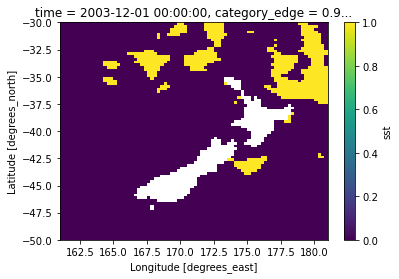

In [70]:
(obs_binary.sel(time='2003-12').squeeze() * mask_obs)['sst'].plot()

In [71]:
forecast_edges = forecast_edges.squeeze()

In [72]:
forecast_edges

<xarray.Dataset>
Dimensions:        (month: 12, lead: 5, lat: 80, lon: 80)
Coordinates:
  * lead           (lead) int64 1 2 3 4 5
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
    category_edge  float64 0.9
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst            (month, lead, lat, lon) float64 dask.array<chunksize=(1, 1, 80, 80), meta=np.ndarray>

In [73]:
forecasts

<xarray.Dataset>
Dimensions:     (init: 288, member: 28, lead: 5, lat: 80, lon: 80)
Coordinates:
  * member      (member) int32 0 1 2 3 4 5 6 7 8 ... 19 20 21 22 23 24 25 26 27
  * lead        (lead) int64 1 2 3 4 5
  * init        (init) object 1993-01-01 00:00:00 ... 2016-12-01 00:00:00
  * lon         (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * lat         (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
    valid_time  (lead, init) object 1993-02-01 00:00:00 ... 2017-05-01 00:00:00
Data variables:
    sst         (init, member, lead, lat, lon) float32 dask.array<chunksize=(288, 28, 1, 80, 80), meta=np.ndarray>

### calculates the 'binary' forecasts for exceeding the climatological 90th percentile 

In [74]:
forecasts_binary = []

for m in np.arange(12) + 1: 
    
    forecastsm = forecasts.sel(init=(forecasts.init.dt.month == m))
    
    forecastsm = forecastsm.rename({'init':'time'})
    
    qm = forecast_edges.sel(month=m)
    
    b = forecastsm >= qm
    
    forecasts_binary.append(b * mask_obs)

In [75]:
forecasts_binary = xr.concat(forecasts_binary, dim='time')

In [76]:
forecasts_binary = forecasts_binary.sortby('time')

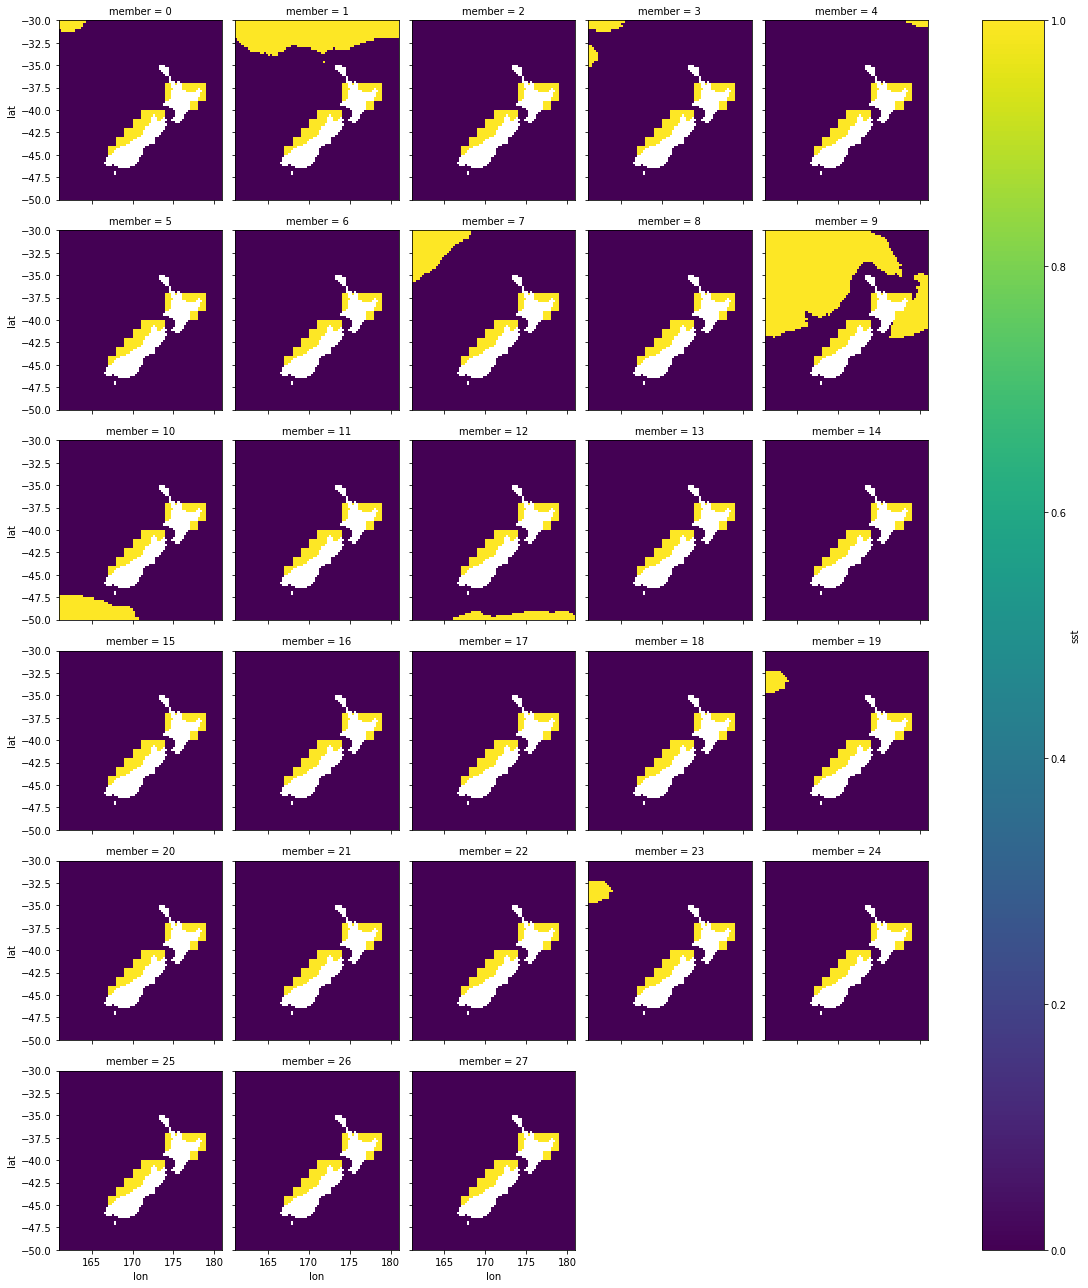

In [77]:
forecasts_binary.sel(time='2002-12',lead=1).squeeze()['sst'].plot(col='member', col_wrap=5)

### calculating the mean of the binary forecasts (0 = not exceeding 90th percentile, 1 = exceeds) is the same as calculating the probability of exceeding the 90th percentile, will vary between 0 and 1

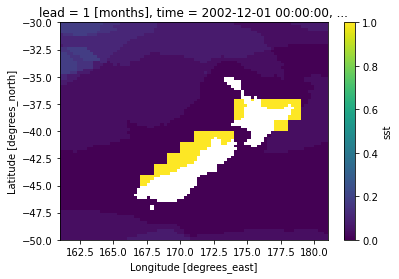

In [78]:
forecasts_binary.sel(time='2002-12',lead=1).mean('member').squeeze()['sst'].plot()

### calculate the anomalies WRT the ensemble mean, to see if the binary forecasts above make sense 

In [79]:
clim = forecasts.mean('member')

In [80]:
clim = clim.groupby(clim.init.dt.month).mean()

In [81]:
clim

<xarray.Dataset>
Dimensions:  (month: 12, lead: 5, lat: 80, lon: 80)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lead, lat, lon) float32 dask.array<chunksize=(1, 1, 80, 80), meta=np.ndarray>

In [82]:
forecasts_anoms = forecasts.groupby(forecasts.init.dt.month) -  clim

In [83]:
forecasts_anoms

<xarray.Dataset>
Dimensions:     (member: 28, lead: 5, init: 288, lon: 80, lat: 80)
Coordinates:
  * member      (member) int32 0 1 2 3 4 5 6 7 8 ... 19 20 21 22 23 24 25 26 27
  * lead        (lead) int64 1 2 3 4 5
  * init        (init) object 1993-01-01 00:00:00 ... 2016-12-01 00:00:00
  * lon         (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * lat         (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
    valid_time  (lead, init) object 1993-02-01 00:00:00 ... 2017-05-01 00:00:00
    month       (init) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst         (init, member, lead, lat, lon) float32 dask.array<chunksize=(1, 28, 1, 80, 80), meta=np.ndarray>

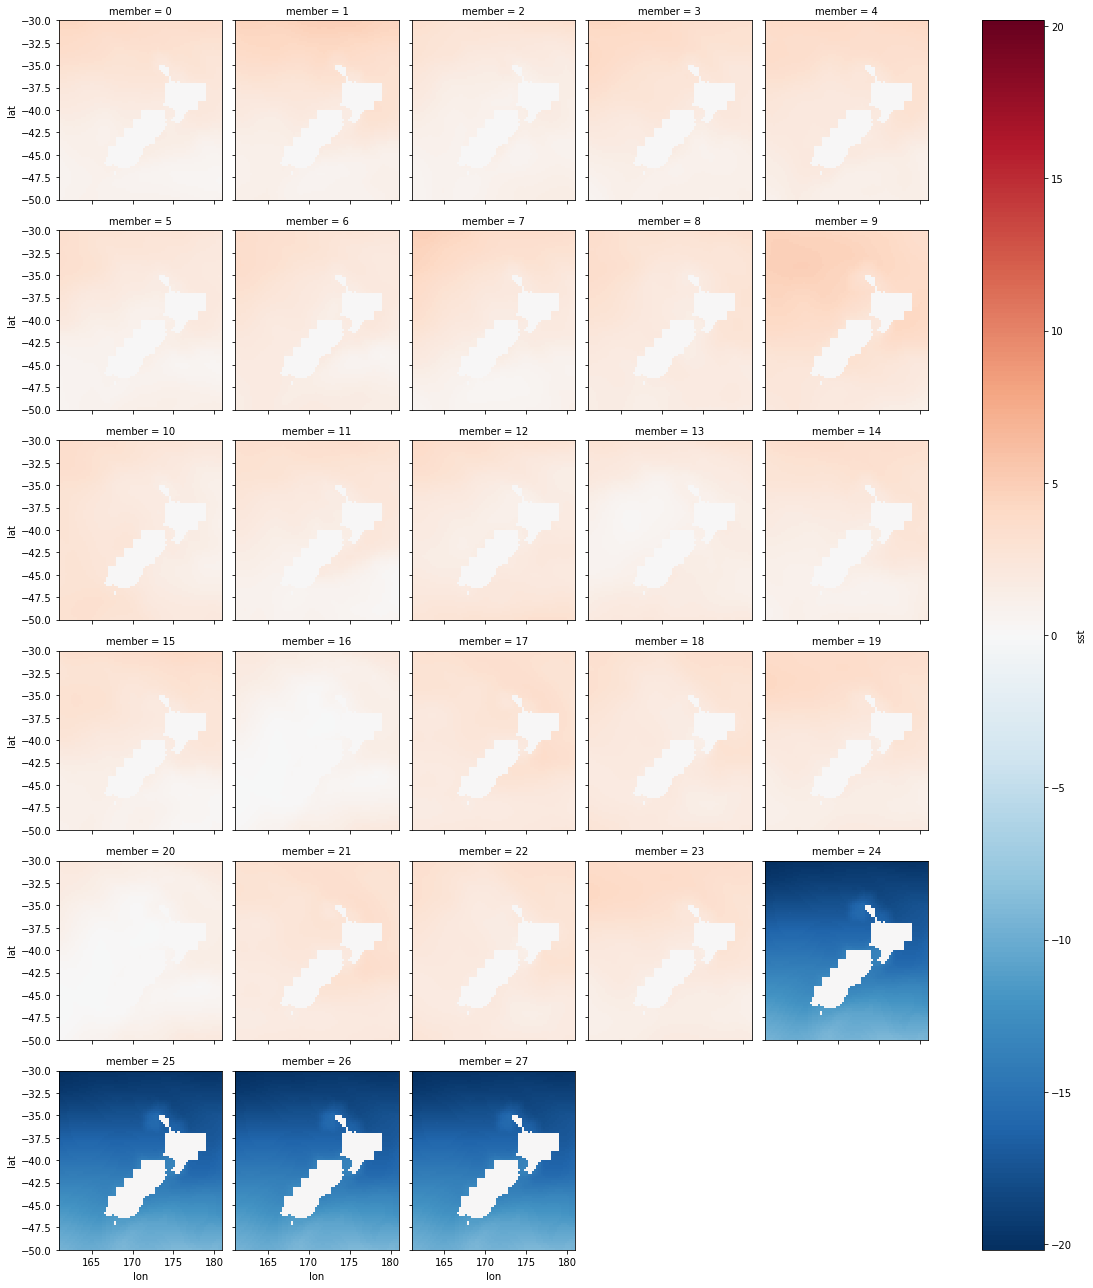

In [84]:
forecasts_anoms.sel(init='2002-12',lead=1).squeeze()['sst'].plot(col='member', col_wrap=5, cmap=plt.cm.RdBu_r)

### try looping over GCMs 

In [85]:
q = 0.9

In [86]:
dgcms = []

for GCM in ['ECMWF','UKMO','METEO_FRANCE','DWD', 'CMCC', 'NCEP', 'JMA', 'ECCC_CanCM4i', 'ECCC_GEM5_NEMO']: 
    
    gcm = C3S.get_one_GCM(dpath=dpath, GCM=GCM, varname=varname, anomalies=False, ensemble_mean=False, domain=domain)
    
    if gcm == 'NCEP': 
        
        print("Interpolating NCEP, calling `interp_NCEP`")
        
        gcm = interp_NCEP(gcm, sst_hindcast_records='./SST_hindcast_summary.csv')

    else: 
        
        gcm[varname] = utils.interpolate_NaN_da(gcm[varname].load())
    
    if period == "seasonal":
        gcm = gcm.rolling({"step": 3}, min_periods=3).mean("step")
        gcm = gcm.sel(step=slice(3, None))
        
    gcm = gcm.transpose( "time", "member", "step", "lat", "lon")
    
    if not (obs_to_1deg):
        
        gcm = gcm.interp_like(dset_obs[["lon", "lat"]])
        
    gcm = gcm.chunk({"member": -1, "time": -1, "step": -1, "lon": 'auto', "lat": 'auto'})
    
    gcm = gcm * mask_obs
    
    gcm = gcm.compute()
    
    # calculate the empirical 90th percentile, for each initial month, across the time + members dimensions 
    
    forecast_edges = (
    gcm.groupby("time.month")
    .quantile(q=q, dim=["time", "member"])
    .rename({"quantile": "category_edge"})
    )
    
    forecast_edges = forecast_edges.squeeze()
    
    # now derive binary forecasts, for each member of the GCM ensemble 
    
    forecasts_binary = []

    for m in np.arange(12) + 1: 
    
        forecastsm = gcm.sel(time=(gcm.time.dt.month == m))
        
        qm = forecast_edges.sel(month=m)
    
        b = forecastsm >= qm
    
        forecasts_binary.append(b * mask_obs)
        
    forecasts_binary = xr.concat(forecasts_binary, dim='time')
    
    forecasts_binary = forecasts_binary.sortby('time')
    
    # add that to the list
    
    dgcms.append(forecasts_binary)

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/ECMWF/SST
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/ECMWF/SST/ensemble_seas_forecasts_sst_from_1993_01_ECMWF.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/ECMWF/SST/ensemble_seas_forecasts_sst_from_2016_12_ECMWF.netcdf
getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/UKMO/SST
reading 287 files

first: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/UKMO/SST/ensemble_seas_forecasts_sst_from_1993_02_UKMO.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/UKMO/SST/ensemble_seas_forecasts_sst_from_2016_12_UKMO.netcdf
getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/METEO_FRANCE/SST
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/METEO_FRANCE/SST/ensemble_seas_forecasts_sst_from_1993_01_METEO_FRANCE.netcd

In [91]:
ds = xr.concat(dgcms, dim='member')

In [92]:
ds.mean('member')

<xarray.Dataset>
Dimensions:        (step: 5, time: 288, lon: 80, lat: 80)
Coordinates:
  * step           (step) int64 1 2 3 4 5
  * time           (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
    category_edge  float64 0.9
Data variables:
    sst            (time, step, lat, lon) float32 0.07317 0.07317 ... 0.151

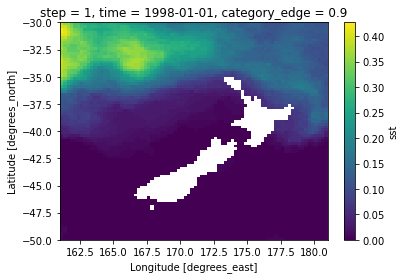

In [93]:
ds.sel(time='1998-01',step=1).mean('member').squeeze()['sst'].plot()

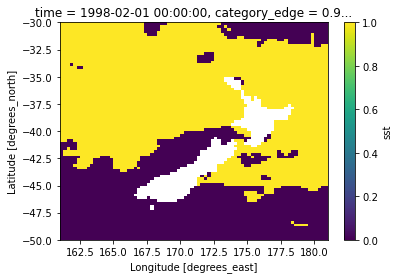

In [94]:
obs_binary.sel(time='1998-02').squeeze()['sst'].plot()